In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import sys
sys.path.append('../../')

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshLChannel
from optimizer import Annealing, AnnealingSolver, PolyTop

# Topology Optimization for L-Channel Flow

## Computational Mesh

In [2]:
# Create Meshes for L-Channel.
n_elem_for_width = 16
mesh_v = MeshLChannel('Q2', n_elem_for_width)
mesh_p = MeshLChannel('Q1', n_elem_for_width)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model

### Boundary Conditions

In [3]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 0.0; v_y = 4*(1.-x)*(2.-x)  
    return np.array([v_x, v_y])

In [4]:
def outlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = -4*(1.-y)*y; v_y = 0.0 
    return np.array([v_x, v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}

for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'outlet':
            boundary_velocity[boundary].append(outlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))
# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        #if boundary == 'inlet' or boundary == 'outlet' or boundary == 'wall':
        if boundary == 'inlet' or boundary == 'wall':
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # TODO: v_x at the outlet should not be prescribed!
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]]) 
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

# Pressure.
BC = []
for boundary in mesh_p.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_p.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall':
            pass
boundary_values_p= np.array(BC)

### Material Properties

In [6]:
viscosity = 1.0; 
density = 1

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density)
fem.set_boudary_values_v(boundary_values_v)

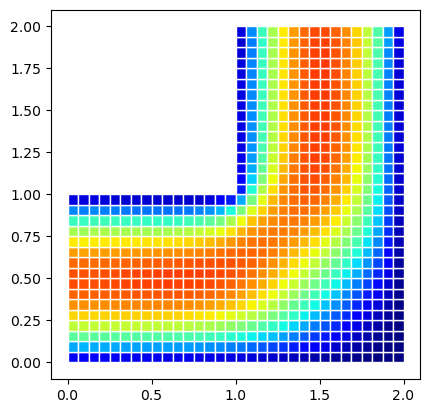

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
coords, elements, boundary_nodes, neighbor_elements=mesh_p.create_mesh_Q1(n_elem_for_width)
from flow_solver import Q2Q1FEM
Q2Q1FEM.Plot_patch(n_elem_for_width,coords,elements,np.sqrt(u_e**2+v_e**2),1.2,0,cmap='jet')

## Classical Optimization

In [9]:
# Settings for Optimization.
volume_fraction_max = 0.75 # Volume fraction.

density_initial = volume_fraction_max*np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_initial_QA = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

design_tolerance = 0.01 # Convergence tolerance on design variables.
max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values = [0.01, 0.1, 1.] #

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.03565979881022728, Volume Fraction: 0.7499617857723386
Iteration: 2, Objective Function: 0.019837371972692003, Volume Fraction: 0.7499495559737118
Iteration: 3, Objective Function: 0.012463657854154176, Volume Fraction: 0.7499799262024505
Iteration: 4, Objective Function: 0.010739768551122564, Volume Fraction: 0.7499996556633354
Iteration: 5, Objective Function: 0.01035659708044776, Volume Fraction: 0.7500435421347443


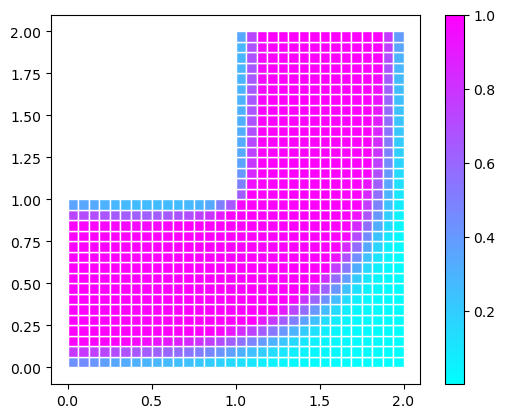

Iteration: 6, Objective Function: 0.010314302088273311, Volume Fraction: 0.7498926438102643
Iteration: 7, Objective Function: 0.010324541477852165, Volume Fraction: 0.7500208002634974


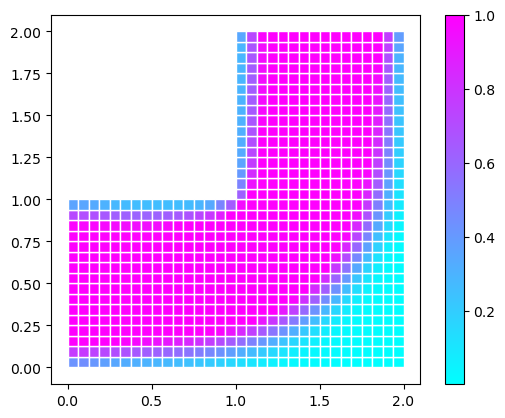

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.015320710090903996, Volume Fraction: 0.7500134945955912
Iteration: 2, Objective Function: 0.012678439452558601, Volume Fraction: 0.7499806046659815
Iteration: 3, Objective Function: 0.012158207377033265, Volume Fraction: 0.7500105325173775
Iteration: 4, Objective Function: 0.012036197946093913, Volume Fraction: 0.7499973923842184
Iteration: 5, Objective Function: 0.01198618703544462, Volume Fraction: 0.7499991233441263


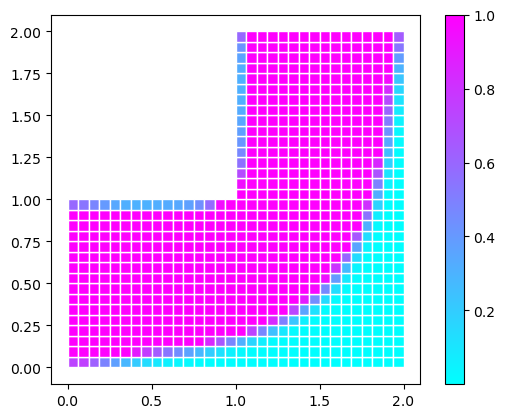

Iteration: 6, Objective Function: 0.011973756273955943, Volume Fraction: 0.749981910468925
Iteration: 7, Objective Function: 0.01196650396052227, Volume Fraction: 0.749996806542854
Iteration: 8, Objective Function: 0.011960981939918324, Volume Fraction: 0.750003951372281
Iteration: 9, Objective Function: 0.011957821928066145, Volume Fraction: 0.7500115624374267
Iteration: 10, Objective Function: 0.011955851713063709, Volume Fraction: 0.7499798729871214


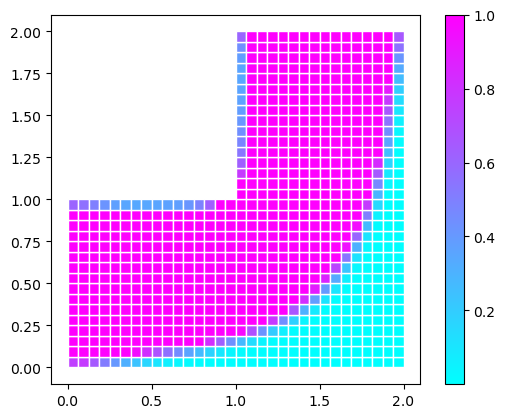

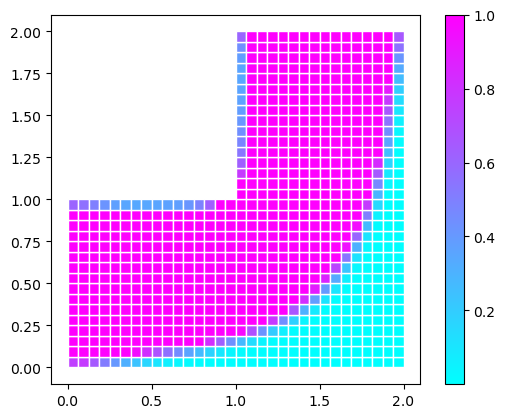

############### q = 1.0 ################
Iteration: 1, Objective Function: 0.013537325433660485, Volume Fraction: 0.7500138956878392
Iteration: 2, Objective Function: 0.01285677659166126, Volume Fraction: 0.7499955710422466
Iteration: 3, Objective Function: 0.012599036803486856, Volume Fraction: 0.7500019292403982
Iteration: 4, Objective Function: 0.012519198655512964, Volume Fraction: 0.7500049531242476
Iteration: 5, Objective Function: 0.012499844592093533, Volume Fraction: 0.7499995259890094


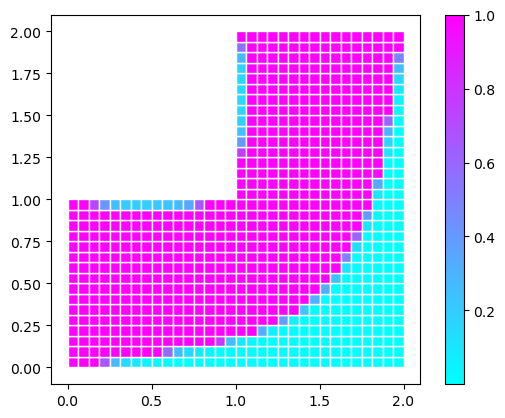

Iteration: 6, Objective Function: 0.012487201914678819, Volume Fraction: 0.7499919203026462
Iteration: 7, Objective Function: 0.012479132113437116, Volume Fraction: 0.7499956142418305
Iteration: 8, Objective Function: 0.012475227111562686, Volume Fraction: 0.7499989781825284
Iteration: 9, Objective Function: 0.012471896185959773, Volume Fraction: 0.7500005704992181
Iteration: 10, Objective Function: 0.012468590565467577, Volume Fraction: 0.7499934193643075


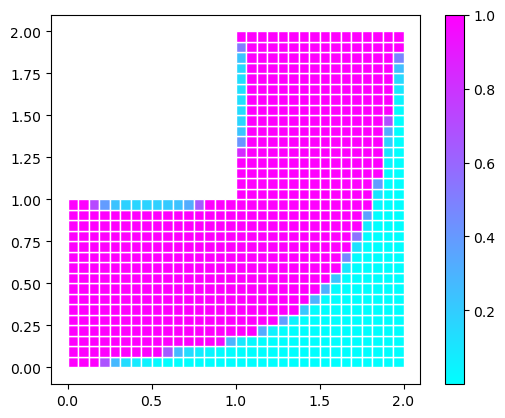

Iteration: 11, Objective Function: 0.012464828052043294, Volume Fraction: 0.7499966097479537
Iteration: 12, Objective Function: 0.012460010560295508, Volume Fraction: 0.7499980467558282
Iteration: 13, Objective Function: 0.012459917437960922, Volume Fraction: 0.7499951558990304
Iteration: 14, Objective Function: 0.012459784065346764, Volume Fraction: 0.7500045933918513
Iteration: 15, Objective Function: 0.012459111487035636, Volume Fraction: 0.7499937743427862


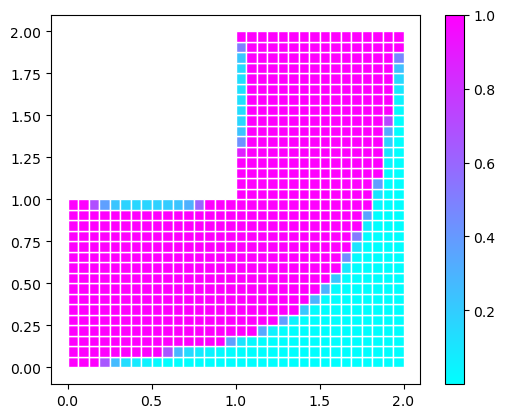

Iteration: 16, Objective Function: 0.012458915665419089, Volume Fraction: 0.7499995548454156
Iteration: 17, Objective Function: 0.012458067889437818, Volume Fraction: 0.7500041597462741
Iteration: 18, Objective Function: 0.012457070952455865, Volume Fraction: 0.7499955326241677
Iteration: 19, Objective Function: 0.012456262142740513, Volume Fraction: 0.7499959128193985
Iteration: 20, Objective Function: 0.012454858107239616, Volume Fraction: 0.7499939510403714


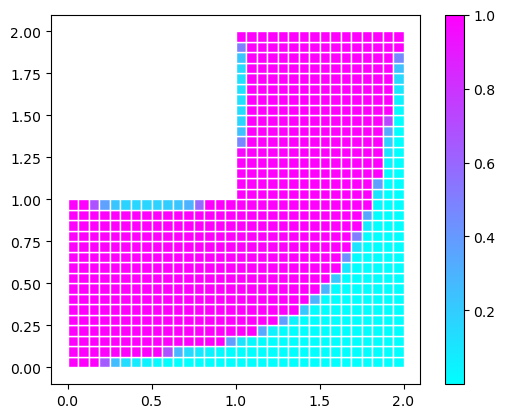

Iteration: 21, Objective Function: 0.012453001273209415, Volume Fraction: 0.750006137575844
Iteration: 22, Objective Function: 0.012450287909741526, Volume Fraction: 0.75000255207789
Iteration: 23, Objective Function: 0.012450252447852589, Volume Fraction: 0.7499992530237461
Iteration: 24, Objective Function: 0.012450304629272102, Volume Fraction: 0.7499956873045828
Iteration: 25, Objective Function: 0.012450416881208683, Volume Fraction: 0.7500057885140579


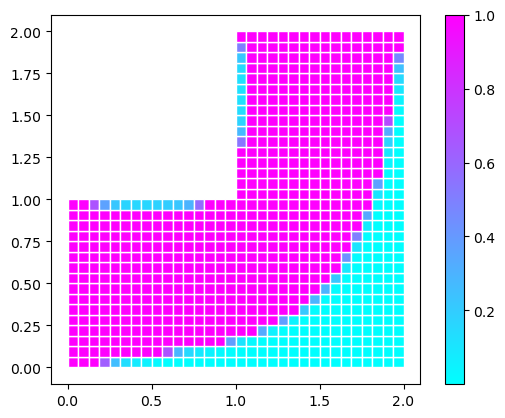

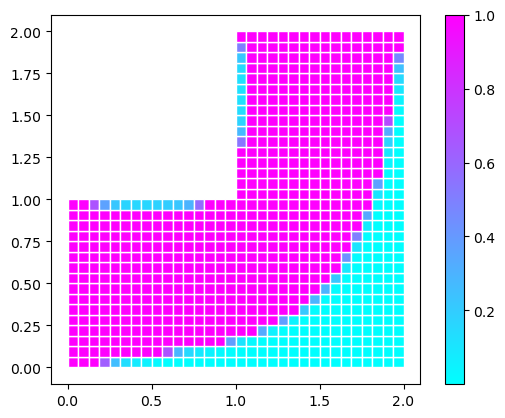

In [15]:
poly_top = PolyTop(fem)
poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                  design_tolerance, max_iterations, q_values,
                  opt_OCMove, opt_OCEta)

### Evaluation

Objective Function:0.012591992582796745, Volume fraction:0.73828125


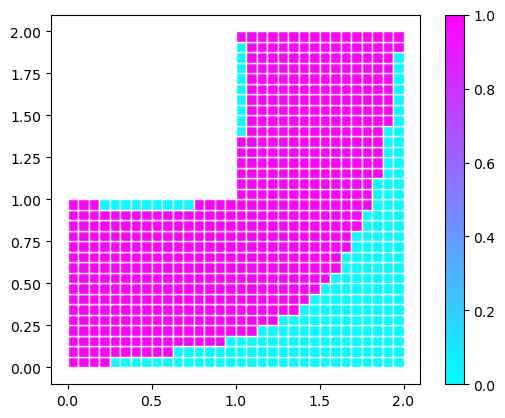

In [27]:
z = poly_top.fem.density
check=[]
for i in range(len(z)):
    if z[i]<=0.5:
        check.append(0)
    else:
        check.append(1)
z_hev=np.array(check)
epsilon = 8*(10**-2)
E_eva = 1./epsilon*(1-z_hev)*1/(1+z_hev)
_, _, _, _, _, f_eva = poly_top.fem.solve(E_eva)
print(f'Objective Function:{f_eva}, Volume fraction:{sum(check)/poly_top.fem.mesh_p.area}')
poly_top.fem.plot_eva(z_hev)

## Optimization with Annealing

In [10]:
from amplify.client import FixstarsClient
client = FixstarsClient()
client.parameters.timeout = 500
client.parameters.outputs.duplicate = True
client.token = 'token '
#client.proxy = ''

annealing_solver = AnnealingSolver(client)

Iteration: 0, Objective Function: 0.017252013650806013, Volume Fraction: 0.7550636574074076


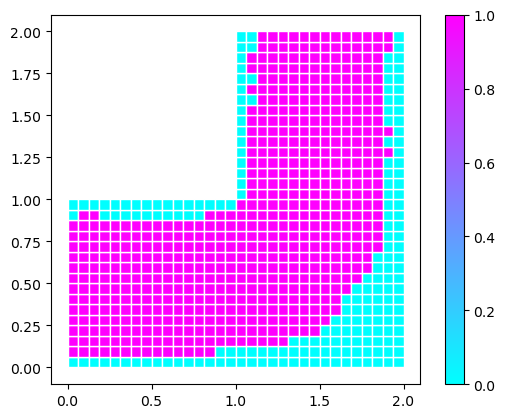

Iteration: 1, Objective Function: 0.014370010633512738, Volume Fraction: 0.7514467592592592


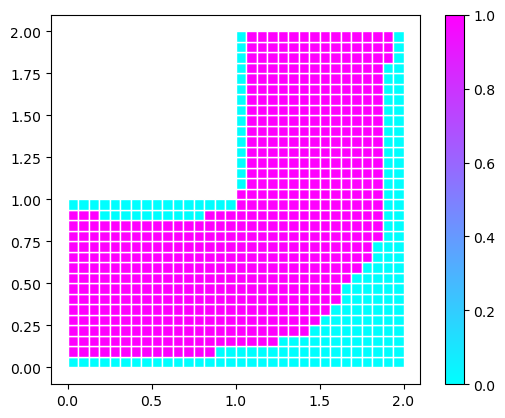

Iteration: 2, Objective Function: 0.013847603900551205, Volume Fraction: 0.7513020833333335


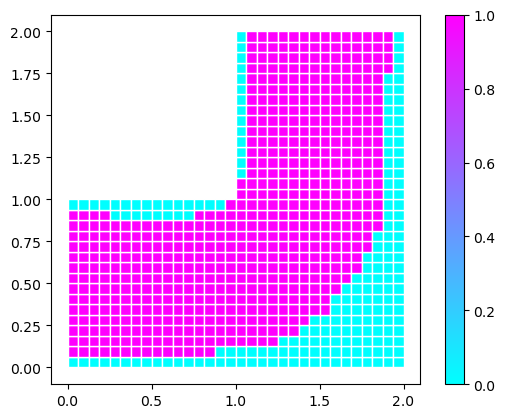

In [11]:
annealing_optimizer = Annealing(fem)
annealing_optimizer.optimize(annealing_solver, 
                             density_initial_QA, density_min, density_max, volume_fraction_max)

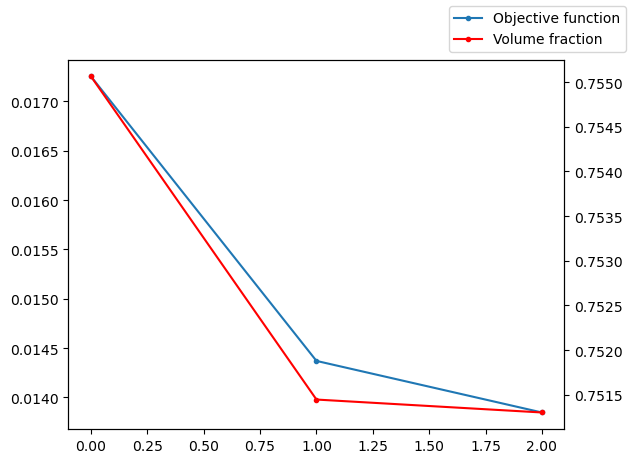

In [12]:
annealing_optimizer.plot_history()